# Trait Weight Based Optimization

In [9]:
#imports required
import numpy as np
import numpy.random as rnd
import scipy
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from numpy import linalg as LA
import cvxpy as cp
import exp_setup
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from trait_weight_optimization.exp_setup import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#installations

### Setup

We will modelling the robot team allocation to solve few independent challenges.

The species will be the 20 types of robots(divided into 4 groups).For each demonstration, each type of robot from the group will be randomly assigned to the expert.

There are 9 traits for each robot specie which are generic and mostly applicable to all of them. 

There are three task which are required to be completed with the allocation. 

In [11]:
# experiment settings
num_species = 4 #drone,rover,mini-rover,mini-drone
num_tasks = 3  #pick,search for target,move object
num_traits = 9 #speed,footprint,payload,reach,weight,sensing frequency,sensing range,color,battery capacity
traits = ["speed","footprint","payload","reach","weight","sensing frequency","sensing range","color","battery"]
num_demo = 1500

## Random Q vs Deterministic Q

### RANDOM Q

In [12]:
Q = []
for i in range(num_demo):
    Q.append(get_random_q())
Q = np.array(Q)
Q.shape

(1500, 4, 9)

NameError: name 'Q' is not defined

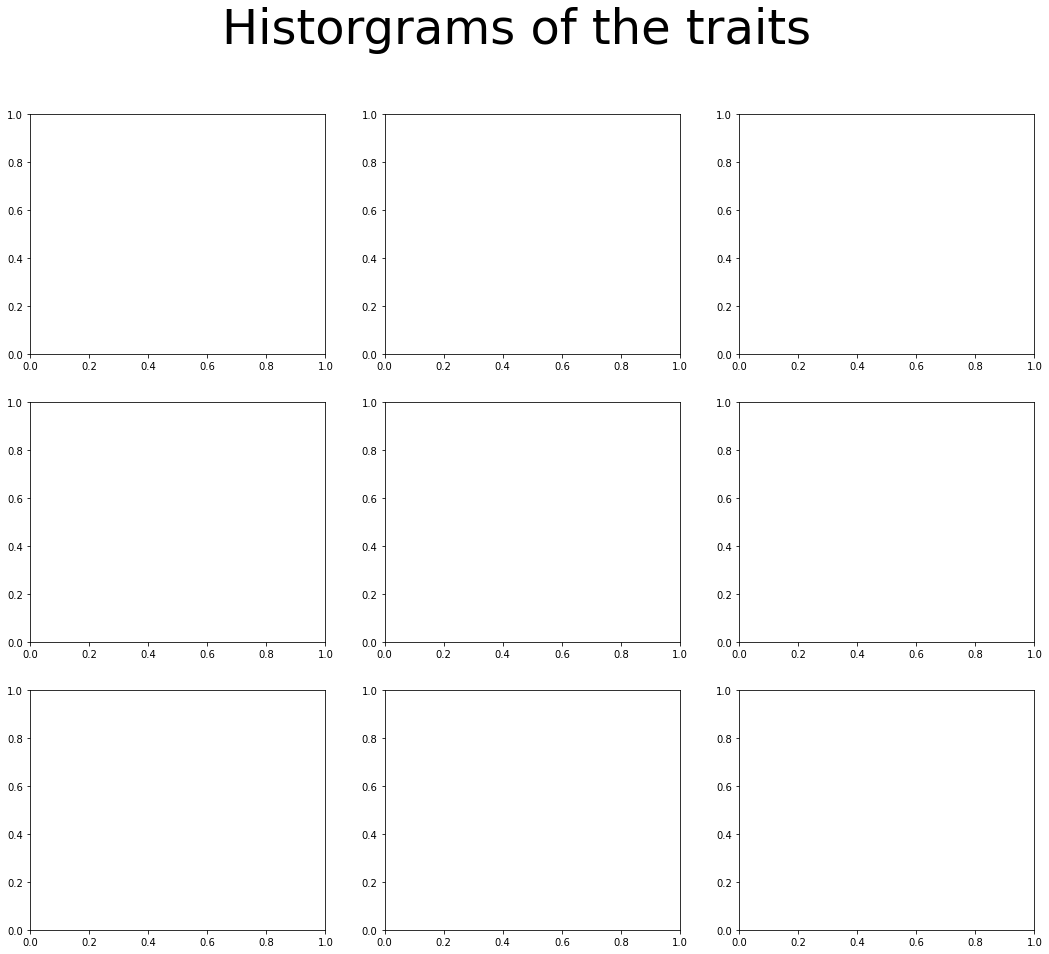

In [45]:
plt.rcParams["figure.figsize"] = (18,15)

create_trait_histogram(plt)
# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.hist(Q[:,:,i], bins=100, density=False,histtype='barstacked', alpha=0.8)

# figure.suptitle("Historgrams of the traits",  fontsize=48)

In [14]:
# #Visualizations
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

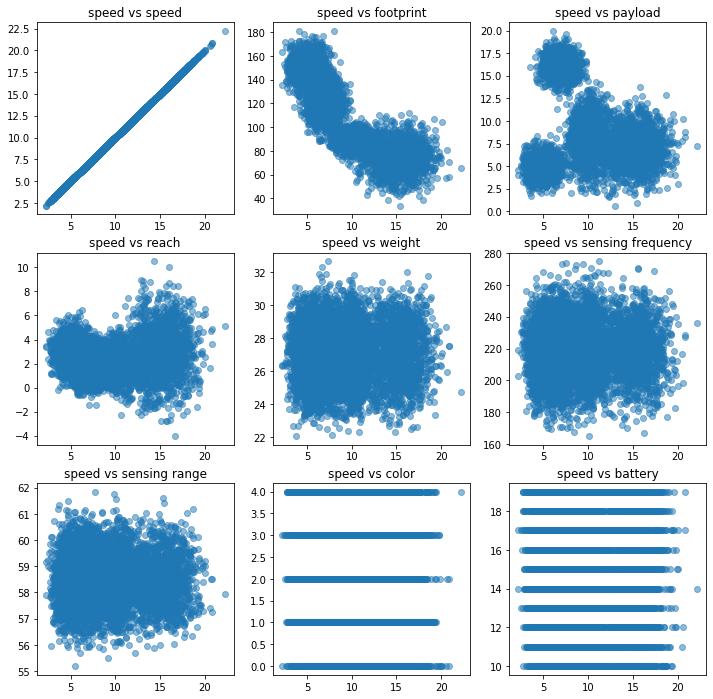

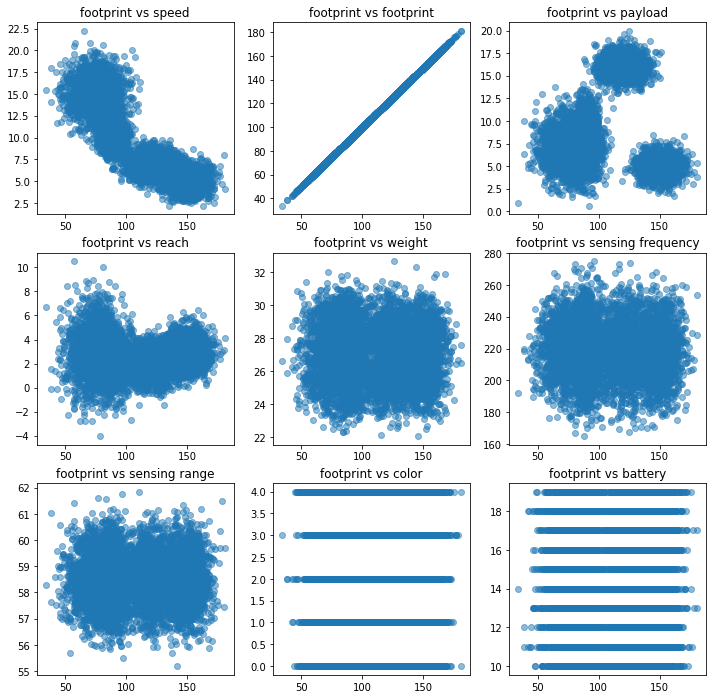

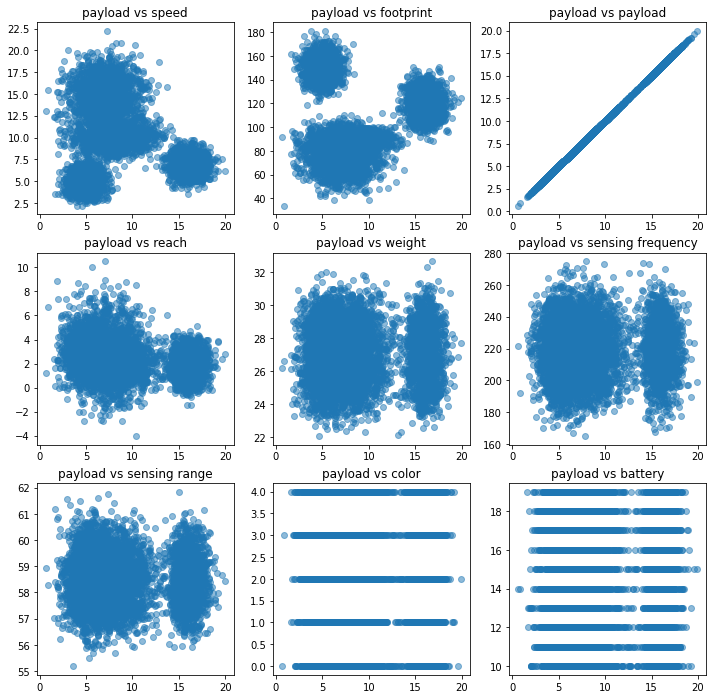

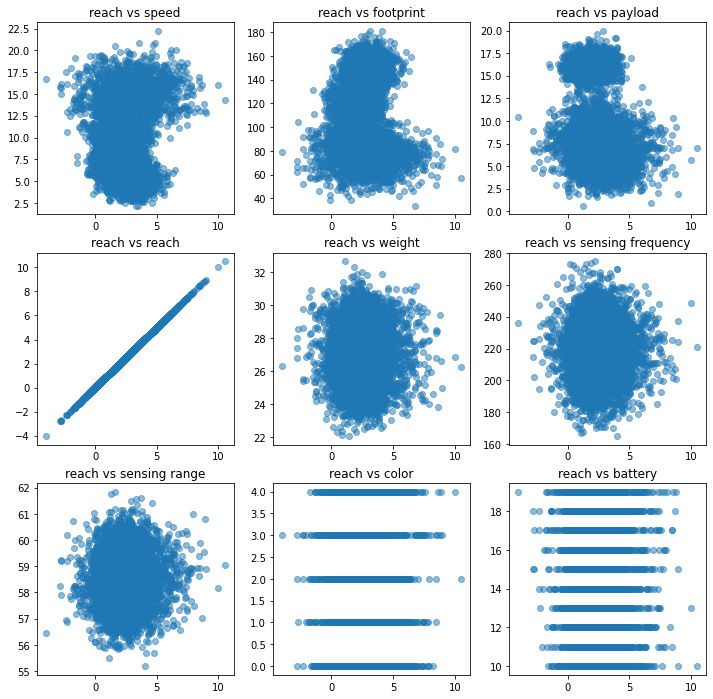

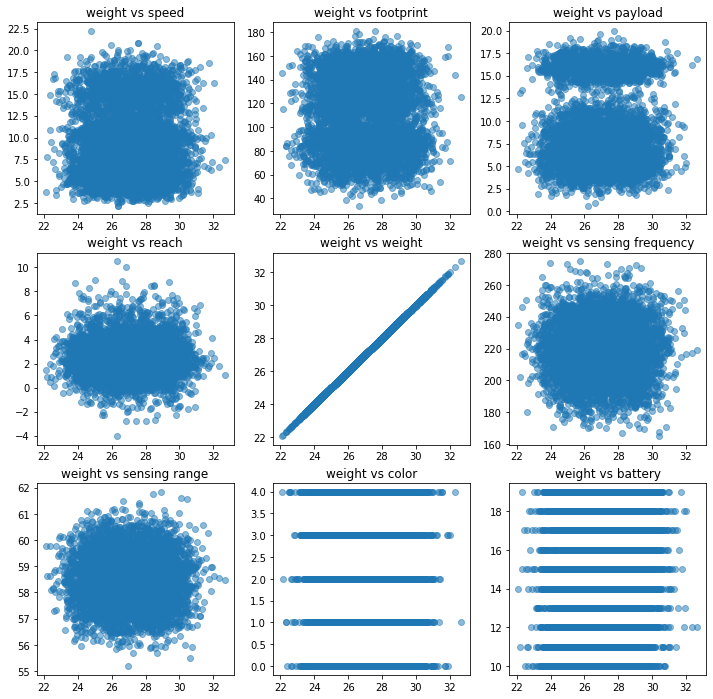

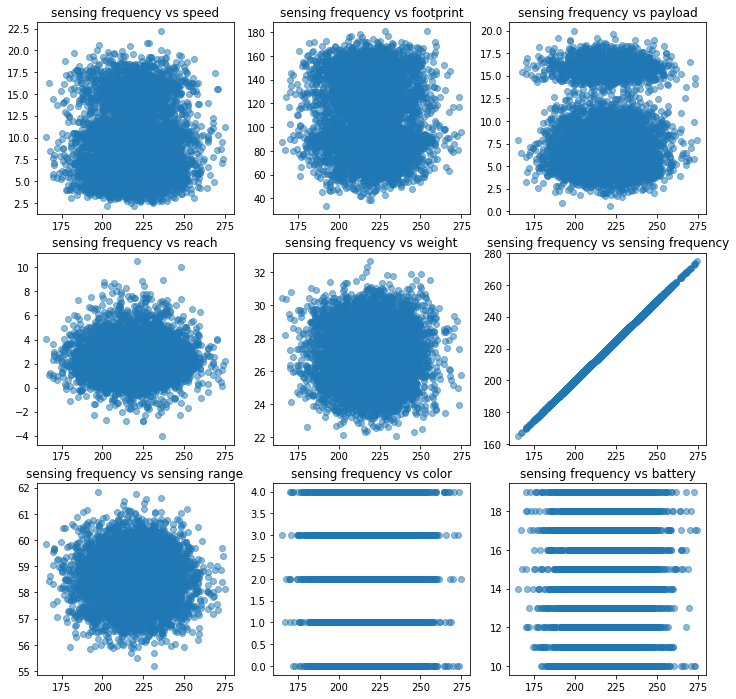

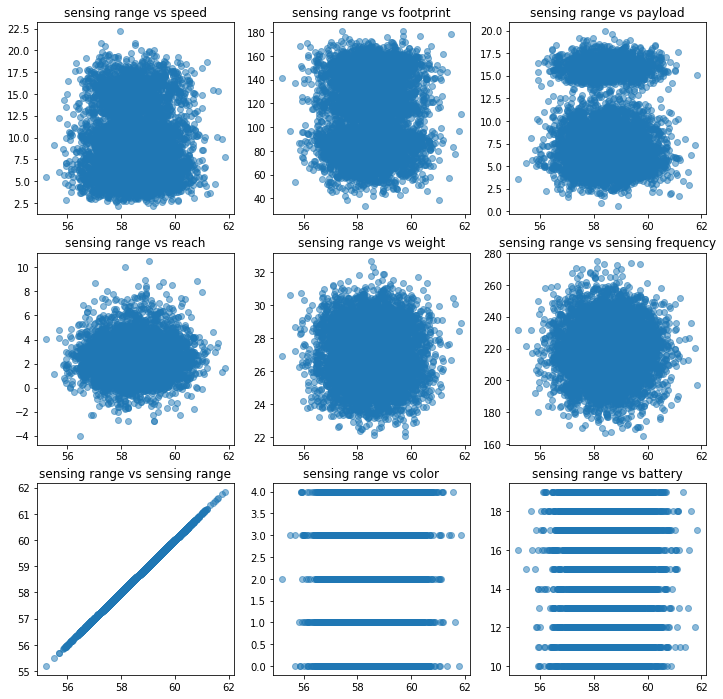

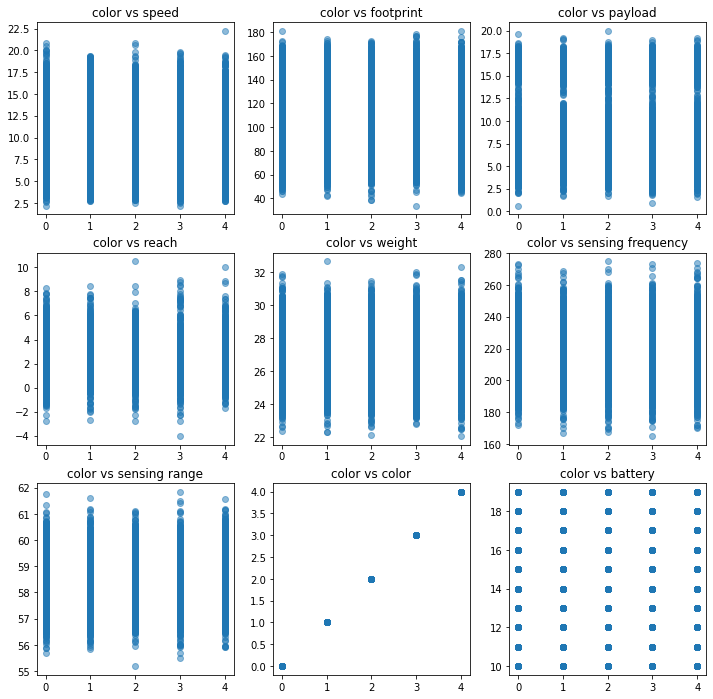

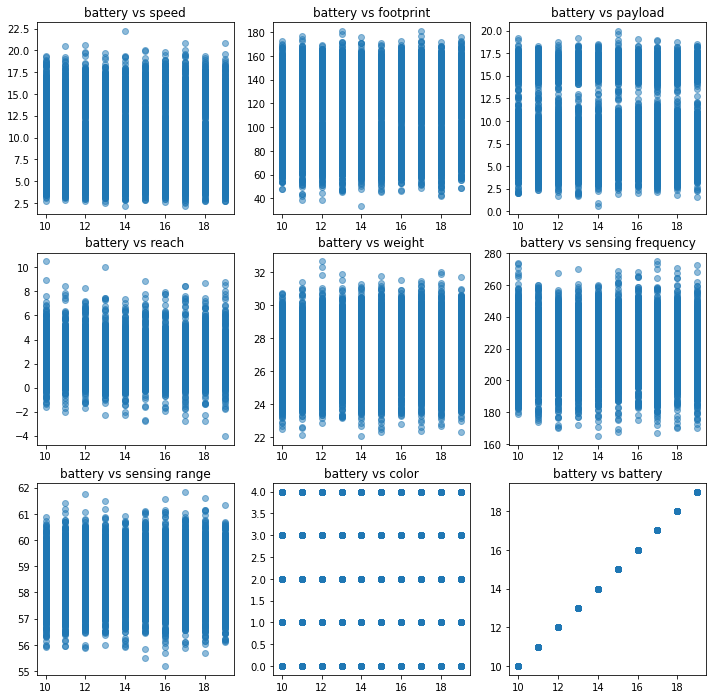

In [15]:
#Visualization Trait space

#Traits with respect to other traits can be mapped to visualize the traits spaces

#Visualizations
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(Q[:,:,t], Q[:,:,i],alpha=0.5)
        ax.set_title(traits[t] + " vs "+ traits[i] )

(DETERMINISTIC Q)
FAILED IDEA

In [16]:
# Q_det = []
# for i in range(num_demo):
#     Q_det.append(get_deterministic_q())
# Q_det = np.array(Q_det)
# Q_det.shape

In [17]:
# plt.rcParams["figure.figsize"] = (18,15)

# #Species across all the 9 traits
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.plot(range(num_demo), Q_det[:,:,i],alpha=0.6)
#     ax.set_title(traits[i])

In [18]:
# plt.rcParams["figure.figsize"] = (12,12)

# #self maps
# figure, axs = plt.subplots(3,3)
# for i, ax in enumerate(axs.flat):
#     ax.scatter(Q_det[:,:,i], Q_det[:,:,i],alpha=0.2)
#     ax.set_title(traits[i] + " vs "+ traits[i] )

# #one trait to another
# for t in range(num_traits):
#     figure, axs = plt.subplots(3,3)
#     for i, ax in enumerate(axs.flat):
#         ax.scatter(Q_det[:,:,t], Q_det[:,:,i],alpha=0.5)
#         ax.set_title(traits[t] + " vs "+ traits[i] )

## Y optimal formualtion

In [19]:
# n_agents_target = np.ones((num_tasks,num_species))*10
# n_agents_target
n_agents_target = np.ones(num_species)*10

In [20]:
#       #speed , footprint , payload , reach , weight , sensing frequency , sensing range,color,battery capacity
# y1 = [167.67539631 , 0 , 163.54336383 , 44.77054672 , 492.53035196 , 4000.24323205 , 1066.20140352 , 0 , 0]#pick
# y2 = [167.26818453 , 1969.70284216 , 0 , 0 , 488.97568317 , 3965.75731709 , 1059.38683684 , 0 , 262.56000000]#search for target
# y3 = [166.81653853 , 1969.43635325 , 161.43957528 , 0 , 488.32231989 , 0 , 1057.86312284 , 0 , 261.07266667]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)
# y_star


# y1 = [163.70974517, 0,  159.18052969,   42.25540358 , 474.86603947,  3915.18485378 ,1044.94916321 ,  0 ,  0]#pick
# y2 = [163.97756868, 1949.61484453 ,0, 0 , 480.46007361,3935.71503043 ,1047.99365735,   0.      ,    253.5       ]#search for target
# y3 = [ 164.43033649, 1957.56082303  ,161.87735218,   0,  486.34644624,0 ,1056.94635674  , 0,         257.5       ]#move object
# y_star = np.array([y1 , y2 , y3]).astype(np.float)

y_star = np.array([[ 122.53839519, 0.,  119.39044525,   32.15983648,
         360.87624558, 2920.25543052,  768.93055775,   0.        ,
         0.        ],
       [ 120.64147124, 1433.4094241 ,  0.,   0.,
         358.13547136, 2906.93229221,  766.11629311,   0.        ,
         190.        ],
       [ 122.31492305, 1441.74082593,  119.06910271,   0.,
         358.78852644, 0. ,  769.11520065,   0.        ,
         193.        ]])

In [21]:
def get_X():
    # X_test = np.random.randint(10, size=((num_tasks, num_traits)))

    X_test = np.zeros((num_tasks, num_species))
    task_restrict = range(num_tasks)
    for s in range(num_species):
        R = np.random.choice(task_restrict, size=n_agents_target[s].astype(int))
        for m in task_restrict:
            X_test[m, s] = np.sum(R == m)
        X_test = X_test.round()
    X_test = X_test.astype(np.int32)
    return X_test

In [22]:
X_test = []
for i in range(num_demo):
    x_i = get_X()
    X_test.append(x_i)
X_test = np.array(X_test)
Y_test = X_test@Q
print(Y_test.shape)
print(np.median(Y_test,axis=0))
print(np.mean(Y_test,axis=0))
print(np.std(Y_test,axis=0))
np.median(Y_test,axis=0)

(1500, 3, 9)
[[ 121.89614347 1420.11082914  117.89535135   31.69582497  353.68809148
  2863.12458334  765.58120831   25.          192.        ]
 [ 122.57281978 1457.2081353   119.11019498   32.31021813  359.3045291
  2933.74696375  770.70147206   25.          193.        ]
 [ 123.35732553 1440.44733289  119.41140895   32.1458347   356.7895688
  2912.16220583  768.49658002   26.          192.        ]]
[[ 122.68513247 1436.29329928  119.11281591   32.78755196  357.19612867
  2894.02341488  773.00299049   26.30333333  192.46266667]
 [ 123.99112942 1460.5266292   121.15546327   33.15066463  361.75637714
  2934.66176822  783.58176094   26.55333333  194.86666667]
 [ 124.29183142 1457.34467704  121.21850789   33.21779722  362.26330124
  2934.62848924  784.1754414    26.47666667  195.05066667]]
[[ 30.30541356 341.013839    31.33084473  12.40785201  82.81329375
  657.10777576 172.03678414  11.61048329  47.92624131]
 [ 32.30969482 340.12690882  32.2976994   12.49359011  82.75610668
  669.770420

array([[ 121.89614347, 1420.11082914,  117.89535135,   31.69582497,
         353.68809148, 2863.12458334,  765.58120831,   25.        ,
         192.        ],
       [ 122.57281978, 1457.2081353 ,  119.11019498,   32.31021813,
         359.3045291 , 2933.74696375,  770.70147206,   25.        ,
         193.        ],
       [ 123.35732553, 1440.44733289,  119.41140895,   32.1458347 ,
         356.7895688 , 2912.16220583,  768.49658002,   26.        ,
         192.        ]])

In [23]:
#weight init
init_weight = np.eye(num_tasks)[np.random.choice(num_tasks, num_traits)].T 
init_weight

array([[0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0., 1., 0.]])

### Experiment setup

In [24]:
X = []
for i in range(num_demo):
    X_sol = cp.Variable((num_tasks, num_species), integer=True)

        # minimize trait mismatch
    mismatch_mat = y_star - cp.matmul(X_sol, Q[i])  # trait mismatch matrix


    obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

    # ensure each agent is only assigned to one task
    constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

    # solve for X_target
    opt_prob = cp.Problem(obj, constraints)
    opt_prob.solve(solver=cp.CPLEX)
    X_target = X_sol.value
    X.append(X_target)


X = np.array(X)

In [46]:
X.shape

(1500, 3, 4)

In [47]:
Y_actual = X@Q
Y_actual.shape

(1500, 3, 9)

In [163]:
# np.sum(((y_star - Y_actual)**2)/(y_star)**2)

# loss = 0
# for m in range(num_tasks):
#     for u in range(num_traits):
#         loss += (((y_star[m,u] - Y_actual[:,m,u])**2)/(m*u*((y_star[m,u])**2)+0.00001))

# loss
# # print(min(loss))
# for i in range(num)
# np.sum((y_star[y_star>0] - Y_actual[y_star>0])**2 / (y_star[y_star>0])**2)

93036064578.80988


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1500 but corresponding boolean dimension is 3

### Elemental Distance


2.3654984538633643
4.013405490107671
9.680092176985468
1000


1500

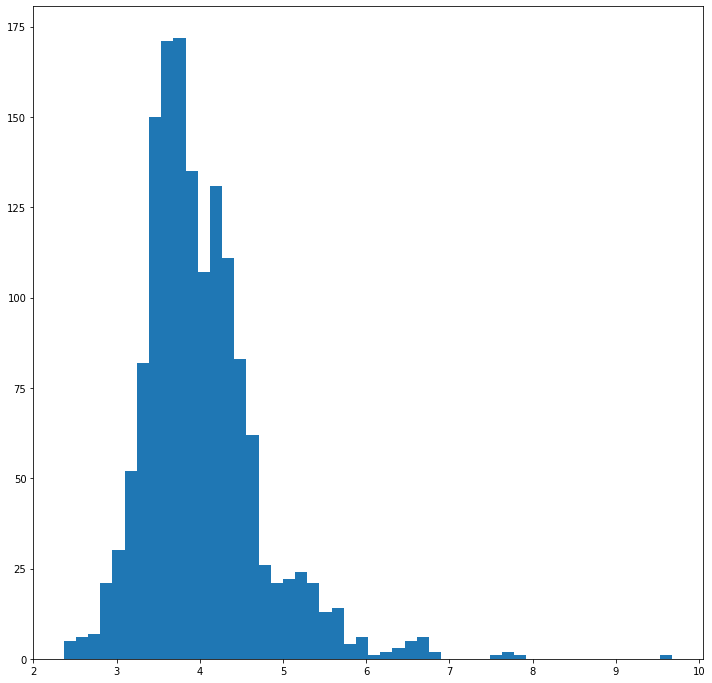

In [164]:
loss = []

for i in range(num_demo):
    l = np.sum((y_star[y_star>0] - Y_actual[i][y_star>0])**2 / (y_star[y_star>0])**2)
    loss.append(l)

print(min(loss))
print(np.mean(loss))
print(max(loss))

ind = np.argpartition(loss, -1000)[-1000:]
print(len(ind))

plt.hist(loss, bins=50)
len(loss)

0.3047374543122127
0.3563988728768312
0.4063903348197441


500

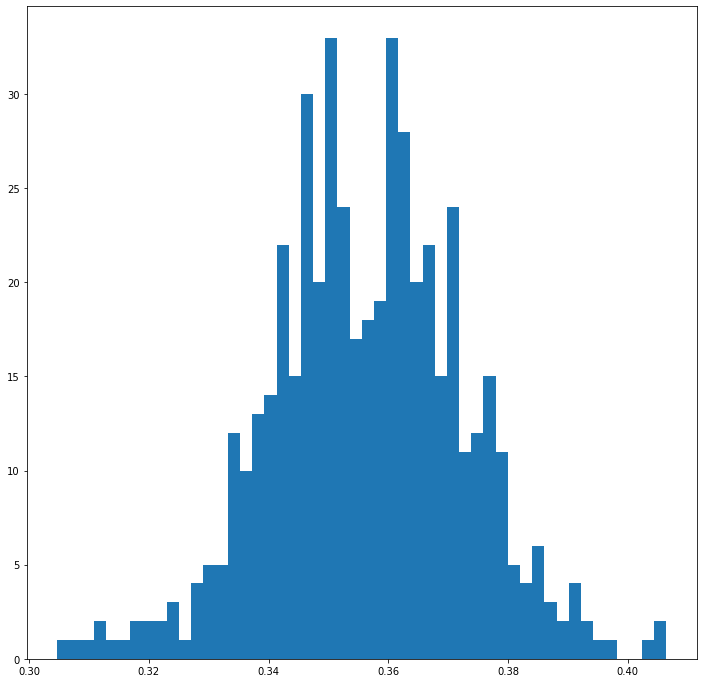

In [165]:
new_Q = np.delete(Q,ind,axis=0)
new_X = np.delete(X,ind,axis=0)
new_Y_actual = new_X@new_Q

new_norms = []
new_demo_count = new_Q.shape[0]
for i in range(new_demo_count):
    new_norms.append(LA.norm(y_star-new_Y_actual[i], 2))

new_norms = np.array(new_norms) / LA.norm(y_star, 2) #Normalization
print(min(new_norms))
print(np.mean(new_norms))
print(max(new_norms))

# plt.scatter(new_norms,np.linspace(0,1,len(new_norms)) )
plt.hist(new_norms,bins=50)
len(new_norms)

### NORM evaluation

0.3047374543122127
0.3573885587764608
0.4071200242735728
1000


1500

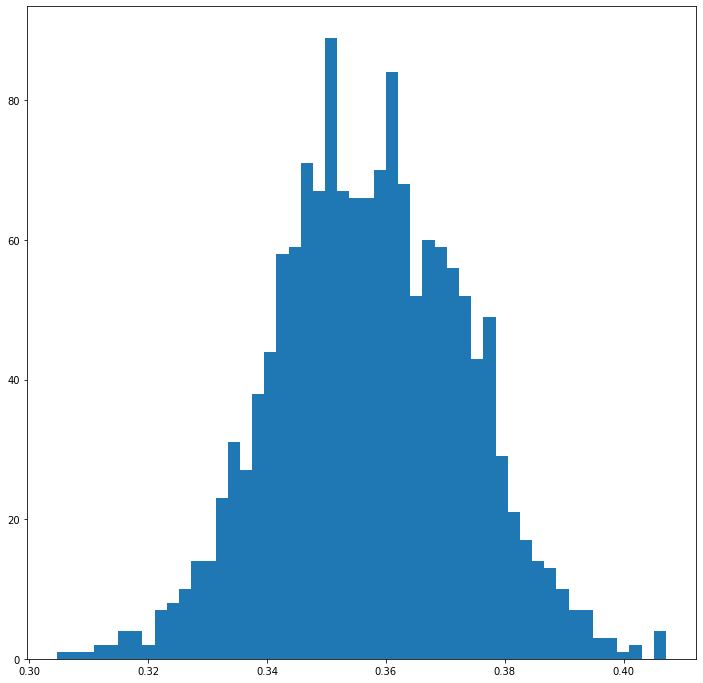

In [114]:
norms = []

for i in range(num_demo):
    norms.append(LA.norm(y_star-Y_actual[i], 2))
norms = np.array(norms)/LA.norm(y_star,2)
print(min(norms))
print(np.mean(norms))
print(max(norms))

ind = np.argpartition(norms, -1000)[-1000:]
print(len(ind))

plt.hist(norms, bins=50)
len(norms)

In [91]:
new_Q = np.delete(Q,ind,axis=0)
new_X = np.delete(X,ind,axis=0)

0.3047374543122127
0.34011045351607216
0.35005896641928774


500

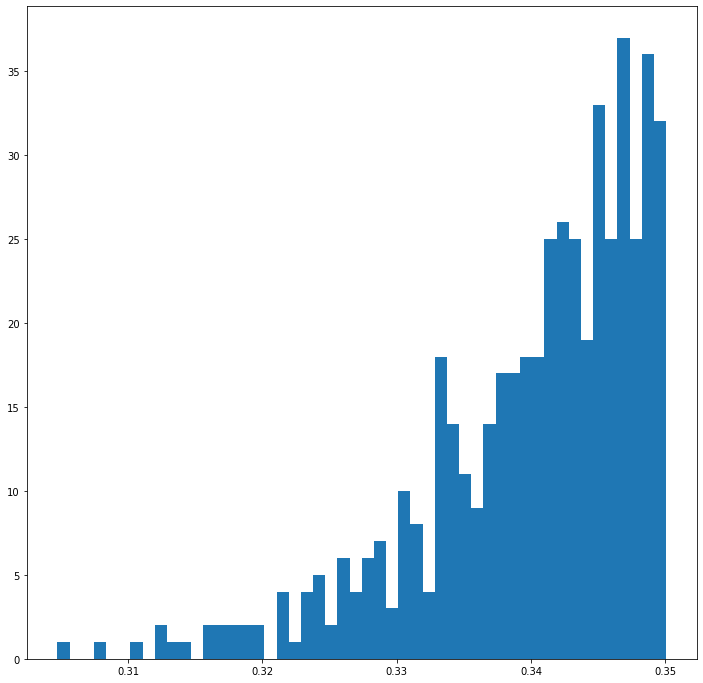

In [116]:
new_Y_actual = new_X@new_Q

new_norms = []
new_demo_count = new_Q.shape[0]
for i in range(new_demo_count):
    new_norms.append(LA.norm(y_star-new_Y_actual[i], 2))

new_norms = np.array(new_norms) / LA.norm(y_star, 2) #Normalization
print(min(new_norms))
print(np.mean(new_norms))
print(max(new_norms))

# plt.scatter(new_norms,np.linspace(0,1,len(new_norms)) )
plt.hist(new_norms,bins=50)
len(new_norms)

In [96]:
D = {'X': new_X, 'Q':new_Q, 'Y': new_Y_actual}
D.keys()

dict_keys(['X', 'Q', 'Y'])

In [72]:
np.mean(new_Y_actual, axis =0)

array([[ 162.72353031,  798.1203538 ,   82.92359785,   32.64639571,
         311.00084854, 2615.64978869,  671.76983961,   23.034     ,
         164.21000002],
       [ 110.83949071, 1456.90975357,  109.2921484 ,   30.09475186,
         356.64863962, 2884.47062907,  772.16740637,   26.828     ,
         190.598     ],
       [  20.74089618,  599.5375203 ,   22.98381455,   11.3094972 ,
         106.77045973,  821.74904097,  231.33720111,    8.07      ,
          57.396     ]])

In [35]:
np.median(new_Y_actual, axis =0)

array([[ 164.21975597,  830.48456385,   83.145281  ,   31.59982706,
         310.46760197, 2602.29407486,  662.07314247,   22.        ,
         166.        ],
       [ 109.96284567, 1453.87793299,  103.69686653,   29.90374067,
         357.17743835, 2884.20284632,  765.6502612 ,   27.        ,
         191.        ],
       [  19.82508833,  597.47478979,   19.94692679,   11.35295479,
         107.31198197,  833.54550741,  233.43167033,    8.        ,
          56.        ]])

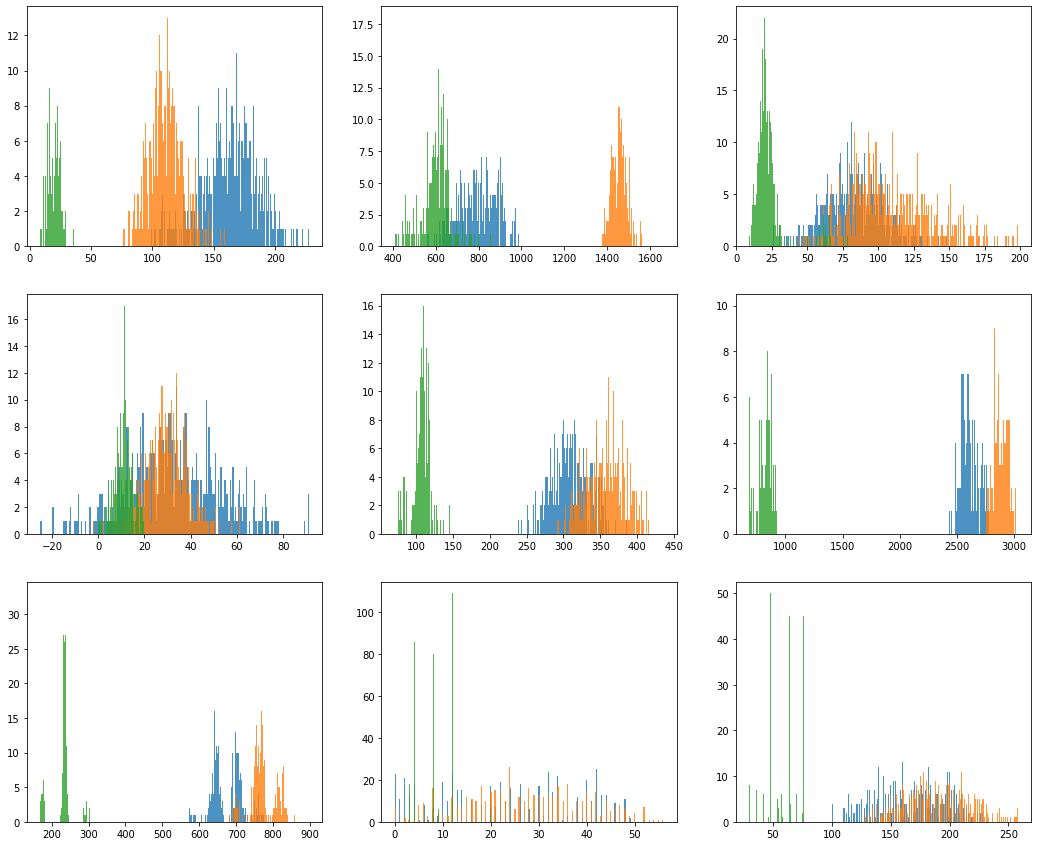

In [73]:
figure, axs = plt.subplots(3,3)
for i, ax in enumerate(axs.flat):
    ax.hist(new_Y_actual[:,0,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,1,i], bins=200, density=False,histtype='barstacked', alpha=0.8)
    ax.hist(new_Y_actual[:,2,i], bins=200, density=False,histtype='barstacked', alpha=0.8)


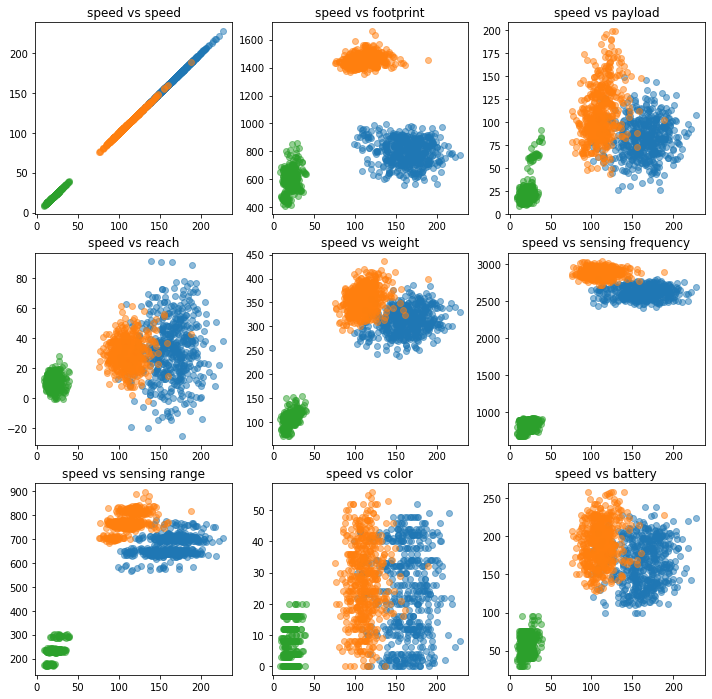

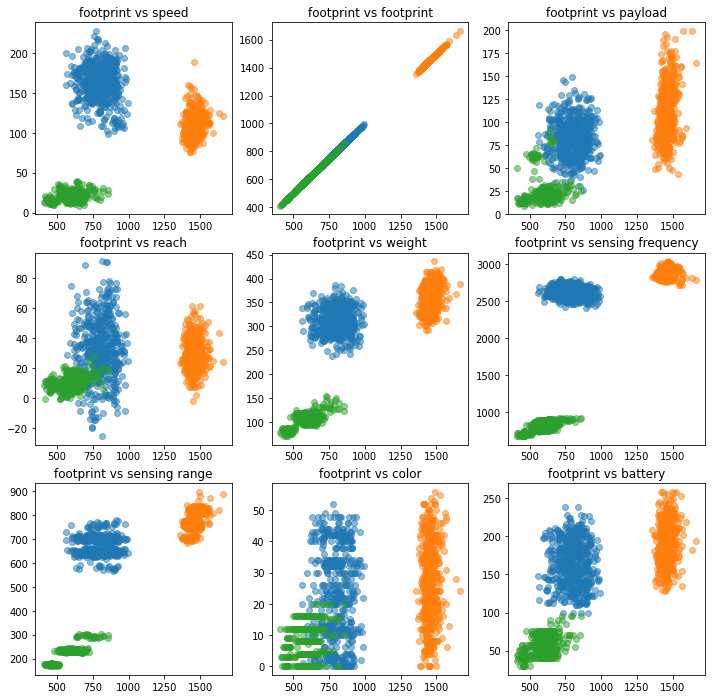

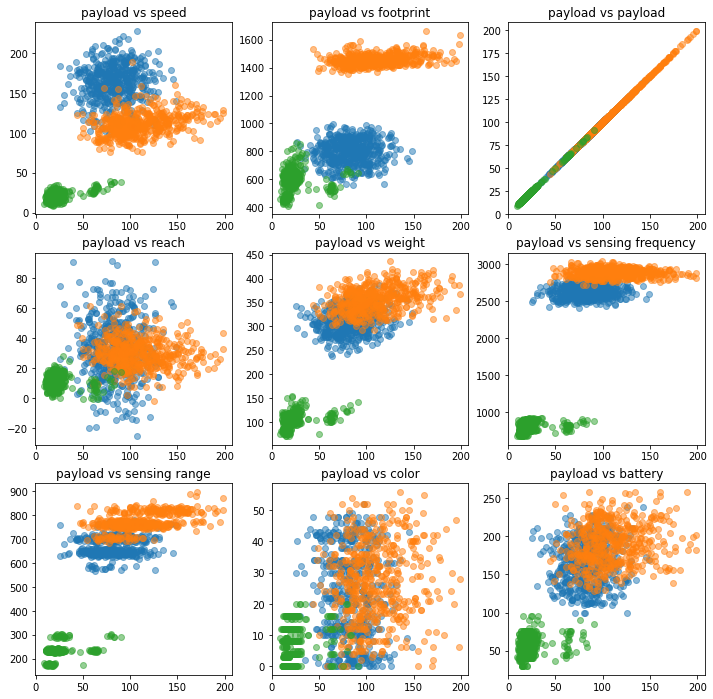

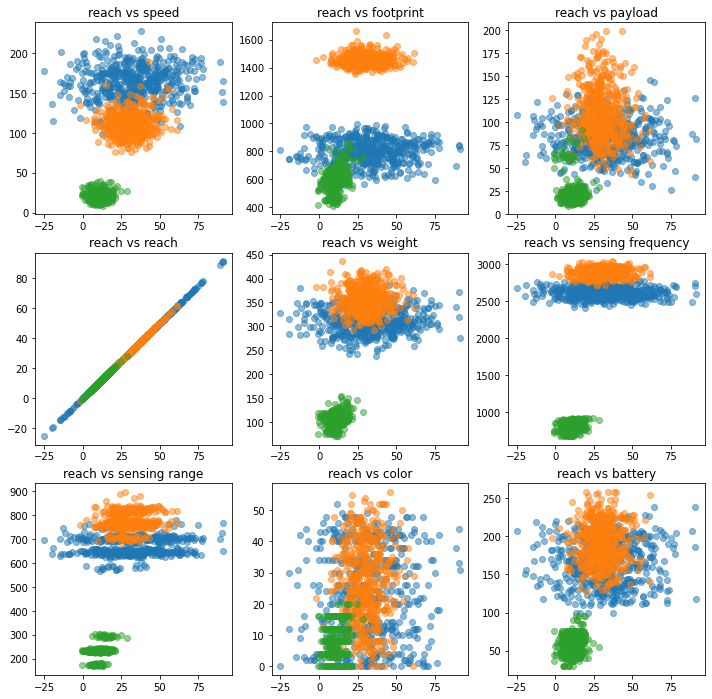

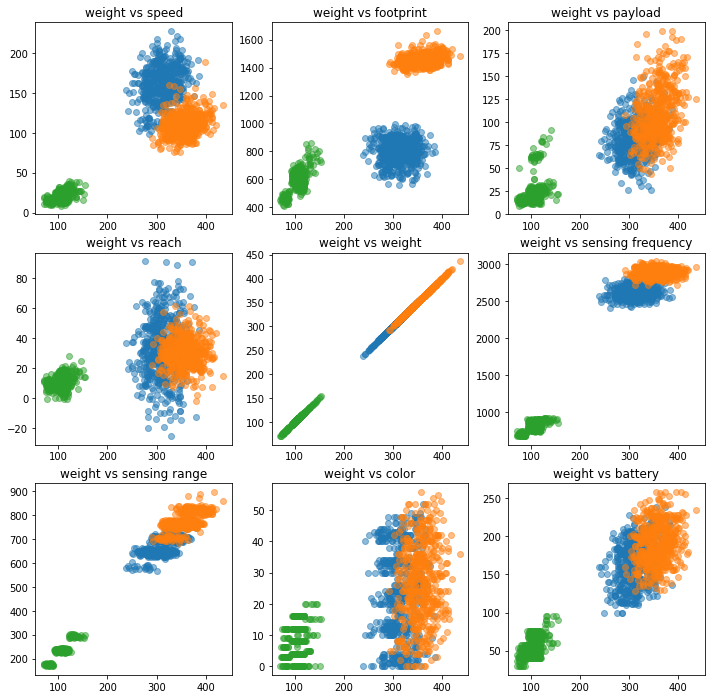

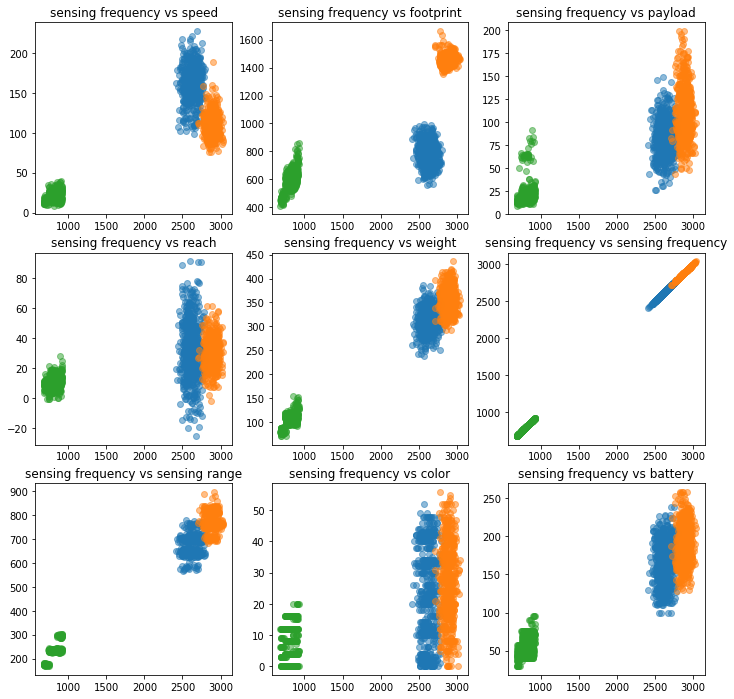

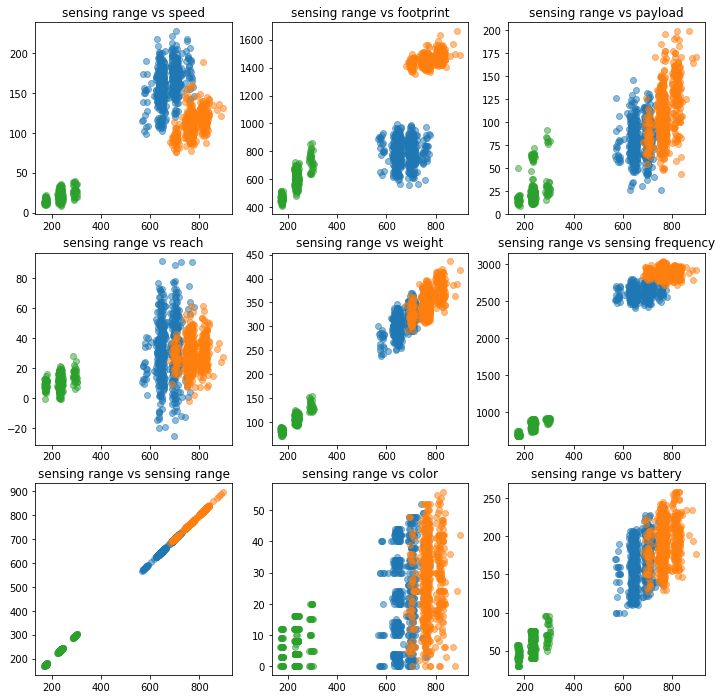

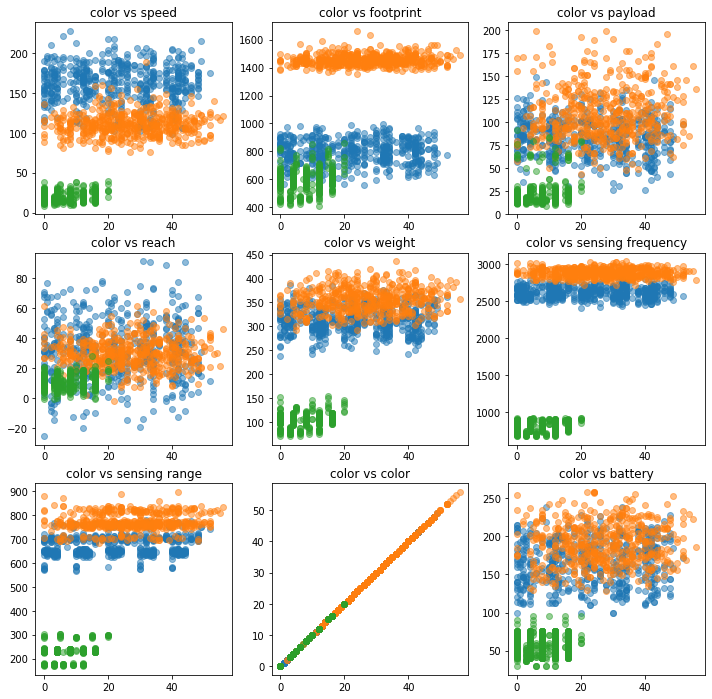

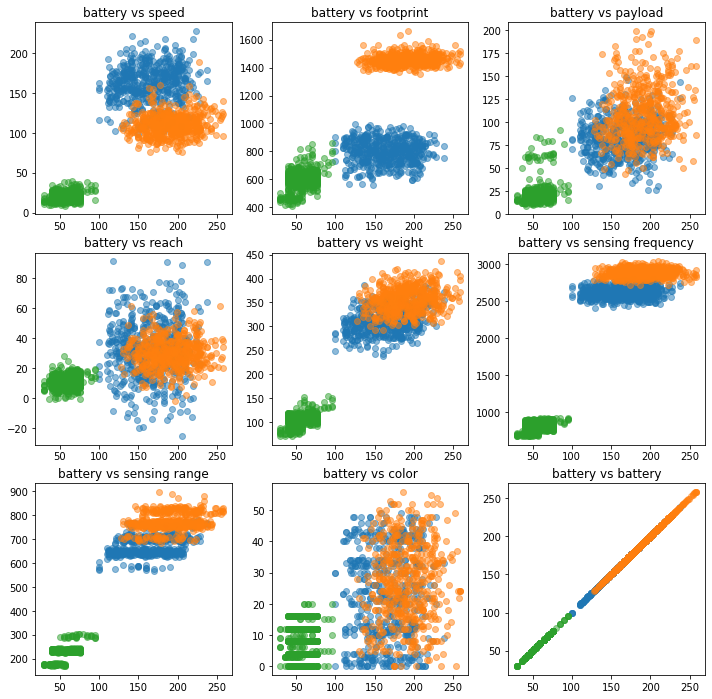

In [74]:
plt.rcParams["figure.figsize"] = (12,12)

#one trait to another
for t in range(num_traits):
    figure, axs = plt.subplots(3,3)
    for i, ax in enumerate(axs.flat):
        ax.scatter(new_Y_actual[:,0,t], new_Y_actual[:,0,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,1,t], new_Y_actual[:,1,i],alpha=0.5)
        ax.scatter(new_Y_actual[:,2,t], new_Y_actual[:,2,i],alpha=0.5)

        ax.set_title(traits[t] + " vs "+ traits[i] )

In [75]:
Var_Y = np.var(new_Y_actual,axis=0)
Var_Y

array([[ 525.61437407, 7654.46783148,  430.09679043,  413.75942386,
         697.09003586, 5758.6917599 , 1615.32629373,  215.37284407,
         897.42190031],
       [ 204.50637478, 1550.77893042,  843.93679597,   91.33028143,
         664.16702554, 3484.59390844, 1300.56456656,  160.54641599,
         753.82839599],
       [  28.46406131, 4936.99609448,  156.54395353,   17.46691411,
         164.00943625, 3597.54690989,  612.41454851,   30.3291    ,
         169.331184  ]])

In [76]:
Var_Q = np.var(new_Q,axis=0)
Var_Q

array([[  0.97707342,  24.02514523,   4.09832378,   0.92244168,
          2.9488936 , 306.26985933,   0.93188145,   1.926124  ,
          7.8456    ],
       [  1.07582821,  81.59036717,   0.99767044,   0.90891569,
          2.77124552, 242.64380601,   0.9202336 ,   1.859884  ,
          8.368844  ],
       [  1.01477693,  97.89082479,   1.0367926 ,   0.98697345,
          2.91355385, 278.51620701,   0.83891892,   2.003916  ,
          7.867824  ],
       [  3.94791765, 116.28206583,   4.08008327,   4.21186643,
          3.1470798 , 210.51540346,   0.93346051,   2.039744  ,
          7.983104  ]])

In [77]:
print(new_Q[0],new_Q[1])

[[  8.55169872  92.17171152   5.90347305   1.32167394  27.77857406
  208.81886664  61.06186321   2.          16.        ]
 [  4.27405279 147.35510845   3.89255537   3.78129691  28.01586137
  229.88652874  59.76763575   4.          12.        ]
 [  7.22060147 109.00159024  15.02066564   2.34815149  28.36945166
  213.50813211  58.98449938   1.          13.        ]
 [ 18.06704184  61.83402029   5.78151453   3.67347557  30.29415556
  243.12981664  59.54256012   1.          16.        ]] [[9.74589676e+00 8.33974567e+01 3.75382599e+00 4.42048353e+00
  2.57725960e+01 2.05725229e+02 5.85505396e+01 0.00000000e+00
  1.90000000e+01]
 [4.74905545e+00 1.51887540e+02 5.07759391e+00 4.25562392e+00
  2.71939609e+01 2.06820082e+02 5.74464269e+01 0.00000000e+00
  1.60000000e+01]
 [7.38035799e+00 1.35147193e+02 1.48948313e+01 2.01618833e+00
  2.71135985e+01 2.04060189e+02 5.70418850e+01 0.00000000e+00
  1.60000000e+01]
 [1.38066846e+01 8.60021348e+01 5.98456575e+00 2.16417156e-01
  2.59231031e+01 2.5830

In [78]:
pca = PCA()
pca.fit(new_Y_actual[:,1,:])
# print(pca.get_covariance().shape)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

print(pca.n_samples_)
print(pca.n_features_)
print(pca.n_components_)
print(pca.singular_values_)

[3552.3577876  2656.46562009  918.28820867  679.64874591  547.84956537
  330.5329155   158.55317638  142.63312761   86.06834296]
[0.39155667 0.29280746 0.10121781 0.07491391 0.06038642 0.03643281
 0.01747644 0.01572166 0.00948684]
500
9
9
[1331.40021632 1151.33676412  676.92378901  582.36133475  522.85460036
  406.1230415   281.27928294  266.78442735  207.23924131]


## IMPLEMENTATION

In [166]:
Q_j = get_random_q()
y_hat = np.mean(new_Y_actual, axis =0)

In [167]:
X_sol = cp.Variable((num_tasks, num_species), integer=True)

# minimize trait mismatch
mismatch_mat = y_hat - cp.matmul(X_sol, Q_j)  # trait mismatch matrix
obj = cp.Minimize(cp.pnorm(mismatch_mat, 2))

# ensure each agent is only assigned to one task
constraints = [cp.matmul(X_sol.T, np.ones([num_tasks, 1])) <= np.array([n_agents_target]).T, X_sol >= 0]

# solve for X_target
opt_prob = cp.Problem(obj, constraints)
opt_prob.solve(solver=cp.CPLEX)
X_target = X_sol.value
print(X_target)

[[ 3. -0.  0.  9.]
 [ 7.  3.  3.  0.]
 [-0.  3.  1. -0.]]


In [82]:
print(LA.norm(y_star-X_target@Q_j,2)/LA.norm(y_star,2))
print(LA.norm(y_star-y_hat,2)/LA.norm(y_star,2))
print(LA.norm(y_hat-X_target@Q_j,2)/LA.norm(y_star,2))

0.3759125145652885
0.33865786085404187
0.05139442464017656


In [168]:
print(LA.norm(y_star-X_target@Q_j,2)/LA.norm(y_star,2))
print(LA.norm(y_star-y_hat,2)/LA.norm(y_star,2))
print(LA.norm(y_hat-X_target@Q_j,2)/LA.norm(y_star,2))

0.3668389392852966
0.3548990441177618
0.022964386760343947
